# ![Specutils: An Astropy Package for Spectroscopy](data/specutils_logo.png)


This notebook provides an overview of the Specutils Astropy coordinated package.  While this notebook is intended as an interactive introduction to specutils at the time of its writing, the canonical source of information for the package is the latest version's documentation: 

https://specutils.readthedocs.io

# Installation

If it is not already installed, installing `specutils` should be as straightforward as either:
```
$ conda install -c conda-forge specutils
```

or

```
$ pip install specutils
```

although for futher information see [the installation section of the docs](https://specutils.readthedocs.io/en/latest/installation.html).

Once these are installed, fundamental imports necessary for this notebook are possible:

In [1]:
import numpy as np

import astropy.units as u

import specutils
from specutils import Spectrum1D
specutils.__version__

'0.5.1'

In [2]:
# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt


# for showing quantity units on axes automatically:
from astropy.visualization import quantity_support
quantity_support();

# Background/Spectroscopic ecosystem

The large-scale plan for spectroscopy support in the Astropy project is outlined in  the [Astropy Proposal For Enhancement 13](https://github.com/astropy/astropy-APEs/blob/master/APE13.rst).  In summary, this APE13 lays out three broad packages:

* `specutils` - a Python package containing the basic data structures for representing spectroscopic data sets, as well as a suite of fundamental spectroscopic analysis tools to work with these data structures.
* `specreduce` - a general Python package to reduce raw astronomical spectral images to 1d spectra (represented as `specutils` objects).
* `specviz` - a Python package (or possibly suite of packages) for visualization of astronomical spectra.


While all are still in development, the first of these is furthest along, and is the subject of this notebook, as it contains the core data structures and concepts required for the others.

# Fundamentals of specutils

## Objects for representing spectra

The most fundamental purpose of `specutils` is to contain the shared Python-level data structures for storing astronomical spectra.  It is important to recognize that this is not the same as the *on-disk* representation.  As desecribed later specutils provides loaders and writers for various on-disk representations, with the intent that they all load to a common set of in-memory/Python interfaces.  Those intefaces (implemented as Python classes) are described in detail in the [relevant section of the documentation](https://specutils.readthedocs.io/en/latest/types_of_spectra.html), which contains this diagram:

![Specutils Classes](data/specutils_classes_diagrams.png)

The core principal is that all of these representations contain a `spectral_axis` attribute as well as a `flux` attribute (as well as optional matching `uncertainty`).  The former is often wavelength for OIR spectra, but might be frequency or energy for e.g. Radio or X-ray spectra.  Regardless of which spectral axis is used, the class attempts to interpret it appropriately, using the features of `astropy.Quantity` to distinguish different types of axes.  Similarly, `flux` may or may not be a traditional astronomical `flux` unit (e.g. Jy or  erg sec$^{-1}$ cm$^{-2}$ angstrom$^{-1}$), but is treated as the portion of the spectrum that acts in that manner.  The various classes are then distinguished by whether these attributes are one-dimensional or not, and how to map the `spectral_axis` dimensionality onto the `flux`.  The simplest case (and the one primarily considered here) is the scalar `Spectrum1D` case, which is a single spectrum with a matched-size `flux` and `spectral_axis`.

## Basics of creating Spectrum1D Objects

While often a spectrum will be loaded from a file (see below), if the format is not compatible, or particular customization is required, spectra can be greated directly from arrays and astropy quantities.  E.g.:

<Spectrum1D(flux=<Quantity [1.98842421, 2.53671295, 1.87050023, 2.03472155, 1.85802086,
           2.18649814, 1.75859482, 2.49251955, 1.8649036 , 1.69891109,
           2.06001827, 2.41358657, 1.9898672 , 2.16581682, 2.0961816 ,
           2.04435195, 2.34244129, 1.78010005, 1.94328673, 2.00215754,
           2.23726335, 2.00957761, 1.89605058, 1.72208922, 1.68202536,
           2.23091555, 2.14440689, 1.96763337, 2.05631947, 2.02081921,
           2.10233039, 1.77614849, 2.2205206 , 2.07296815, 2.00997632,
           2.34659703, 2.17120427, 2.06512796, 1.9459567 , 1.8896631 ,
           2.05481387, 2.07486046, 1.8090483 , 1.92777493, 1.97077933,
           2.4633664 , 2.33482568, 2.16533922, 2.42346757, 2.0134885 ,
           1.92278507, 2.17241829, 2.23054718, 2.27250085, 2.04267149,
           2.17721838, 1.67574442, 2.00403915, 1.71913301, 2.13607716,
           1.66149314, 2.21163904, 2.30487598, 1.94533512, 1.97123262,
           2.0077287 , 1.4989347 , 1.91507711, 2.23099335, 1

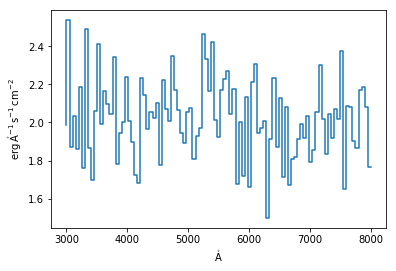

In [3]:
flux = (np.random.randn(100)*0.2 + 2) * u.erg / u.s / (u.cm**2) / u.AA 
wavelength = np.linspace(3000, 8000, 100)*u.AA
spec1d = Spectrum1D(spectral_axis=wavelength, flux=flux)

plt.step(spec1d.spectral_axis, spec1d.flux)

spec1d

These can be straightforwardly transformed to other spectral units if desired:

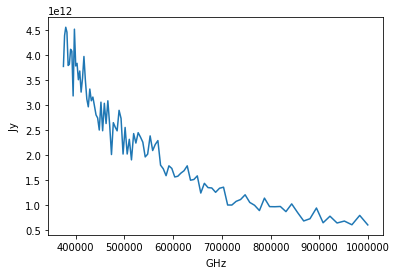

In [4]:
jyspec1d = spec1d.new_flux_unit(u.Jy)
plt.plot(jyspec1d.frequency, jyspec1d.flux)

## Uncertainties

Currently the most compatible way to use uncertainties is the machinery built for the `astropy.nddata` object (although in many cases simply passing in an uncertainty array will also work):

<ErrorbarContainer object of 3 artists>

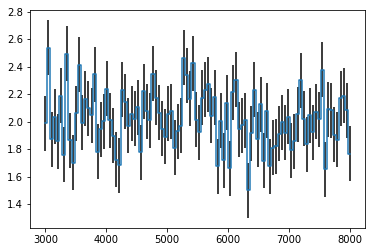

In [5]:
from astropy.nddata import StdDevUncertainty

unc = StdDevUncertainty(0.2 * np.ones(100))
spec1d_unc = Spectrum1D(spectral_axis=wavelength, flux=flux, uncertainty=unc)

# the errorbar matplotlib function does not natively support quantities
plt.errorbar(spec1d_unc.wavelength.value, 
             spec1d_unc.flux.value, 
             spec1d_unc.uncertainty.array,
             fmt='-',
             drawstyle='steps-mid',
             ecolor='k')

### Exercise

Create a `Spectrum1D` object for an ideal 5800 K blackbody and plot it. Try the same, but with (random) noise added and stored as the uncertainty.

Hint: while you can do this manually if you know the Planck function, there is an Astropy function to help you with this - you can find it via appropriate searches in the [astropy docs](http://docs.astropy.org).

<ErrorbarContainer object of 3 artists>

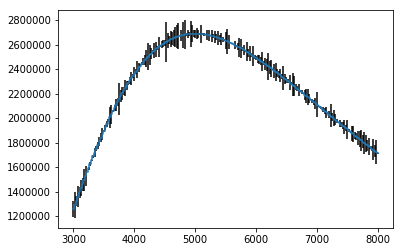

In [52]:
import astropy.modeling as modeling

npts = 201
T = 5800
wl_AA = np.linspace(3000, 8000, npts)*u.AA

# Compute the fluxes for a 5800K Blackbody
BB_flux = modeling.blackbody.blackbody_lambda(wl_AA, T)

# Generate Gaussian noise
noise_mdl = np.random.normal(0., 0.1*np.max(BB_flux.value), npts)
BB_unc = StdDevUncertainty(np.random.normal(0., 0.02*np.max(BB_flux.value), npts))

# Build Spectrum1D object
spec1d_BB = Spectrum1D(spectral_axis=wl_AA, flux=BB_flux, uncertainty=BB_unc)

# the errorbar matplotlib function does not natively support quantities
plt.errorbar(spec1d_BB.wavelength.value, 
             spec1d_BB.flux.value, 
             spec1d_BB.uncertainty.array,
             fmt='-',
             drawstyle='steps-mid',
             ecolor='k')

## Loading spectra from files

Specutils also comes with readers for a variety of spectral data formats (including loaders for future JWST instruments). While support for specific formats depends primarily from users (like you!) providing readers, you may find that one has already been implemented for your favorite spectrum format.  As an example, we consider a spectrum form the [Sloan Digital Sky Survey](http://skyserver.sdss.org/):

In [53]:
from urllib.request import urlretrieve

url = 'https://dr14.sdss.org/optical/spectrum/view/data/format=fits/spec=lite?plateid=1323&mjd=52797&fiberid=12'
urlretrieve(url, 'data/sdss_spectrum.fits')

('data/sdss_spectrum.fits', <http.client.HTTPMessage at 0x1c23cb3208>)

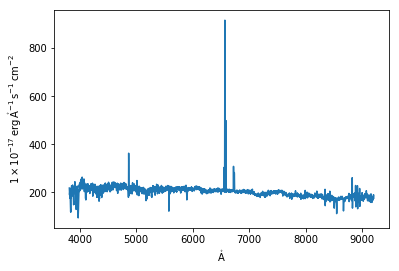

In [54]:
sdss_spec = Spectrum1D.read('data/sdss_spectrum.fits', format='SDSS-III/IV spec')
plt.plot(sdss_spec.wavelength, sdss_spec.flux)

To see the full list of formats readable in your current version of specutils, see the table at the bottom of the `Spectrum1d.read` method:

In [55]:
help(Spectrum1D.read)

Help on method read in module astropy.nddata.mixins.ndio:

read(*args, **kwargs) method of abc.ABCMeta instance
    Generate a CCDData object from a FITS file.
    
    Parameters
    ----------
    filename : str
        Name of fits file.
    
    hdu : int, optional
        FITS extension from which CCDData should be initialized. If zero and
        and no data in the primary extension, it will search for the first
        extension with data. The header will be added to the primary header.
        Default is ``0``.
    
    unit : `~astropy.units.Unit`, optional
        Units of the image data. If this argument is provided and there is a
        unit for the image in the FITS header (the keyword ``BUNIT`` is used
        as the unit, if present), this argument is used for the unit.
        Default is ``None``.
    
    hdu_uncertainty : str or None, optional
        FITS extension from which the uncertainty should be initialized. If the
        extension does not exist the uncertai

### Exercise

If you have your own spectroscopic data, try loading a file here using either one of the built-in loaders, or the `Spectrum1D` interface, and plotting it.  If you don't have your own data on-hand, try downloading something of interest via a public archive (e.g., public HST data using MAST), and load it.

# Manipulating spectra

In addition to the analysis tools described in more detail in [the next notebook](Specutils_analysis.ipynb), Specutils also provides functionality for manipulating spectra.  In general these follow the pattern of creating *new* specutils objects with the results of the operation instead of in-place operations.

The most straightforward of operations are arithmetic manipulations.  In general these follow expected patterns. E.g.:

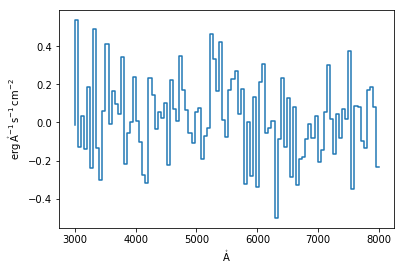

In [56]:
newspec1d = spec1d - 2 * u.erg / u.s / (u.cm**2) / u.AA
plt.step(newspec1d.wavelength, newspec1d.flux)

However, when there is ambiguity in your intent - for example, two spectra with different units where it is not clear what the desired output is - errors are generally produced instead of the code attempting to guess:

In [57]:
newspec1d - jyspec1d

UnitConversionError: Can only apply 'subtract' function to quantities with compatible dimensions

Resolving this requires explicit conversion:

In [58]:
spec1d.new_flux_unit(u.Jy) - jyspec1d

<Spectrum1D(flux=<Quantity [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0.] Jy>, spectral_axis=<Quantity [3000.        , 3050.50505051, 3101.01010101, 3151.51515152,
           3202.02020202, 3252.52525253, 3303.03030303, 3353.53535354,
           3404.04040404, 3454.54545455, 3505.05050505, 3555.55555556,
           3606.06060606, 3656.56565657, 3707.07070707, 3757.57575758,
           3808.08080808, 3858.58585859, 3909.09090909, 3959.5959596 ,
           4010.1010101 , 4060.60606061, 4111.11111111, 4161.61616162,
           4212.12121212, 4262.62626263, 4313.13131313, 4363.

### Exercise

Take the blackbody spectrum you generated above, and create a "spectral feature" by adding a gaussian absorption or emission line to it using the arithmetic operators demonstrated above.

<ErrorbarContainer object of 3 artists>

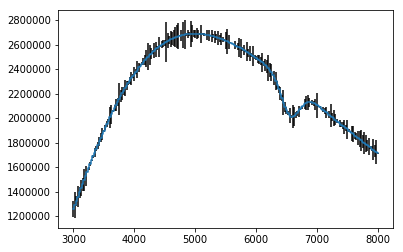

In [59]:
# H alpha wavelength (Ångstroms)
wl_Halpha = 6562.81

# Line-width (QSO line?)
linewidth = 150 

# Generate the line spectrum using astropy.modeling (NOTE: We may not cover modelling in workshop)
line_model = modeling.functional_models.Gaussian1D(amplitude=-0.1*np.max(BB_flux.value), mean=wl_Halpha, stddev=linewidth)
line_flux = line_model(wl_AA.value)*BB_flux.unit
linespec = Spectrum1D(spectral_axis=wl_AA, flux=line_flux)

# Generating the spectrum with the absorption line in it
final_spec = spec1d_BB + linespec

# Plot the final spectrum using matplotlib (without uncertainty)
plt.errorbar(final_spec.wavelength.value, 
             final_spec.flux.value, 
             final_spec.uncertainty.array,
             fmt='-',
             drawstyle='steps-mid',
             ecolor='k')

## Smoothing, etc.

More complex manipulation tools exist, outlined in the [relevant doc section](https://specutils.readthedocs.io/en/latest/manipulation.html). As a final example of this, we smooth our example spectrum using Gaussian smoothing:

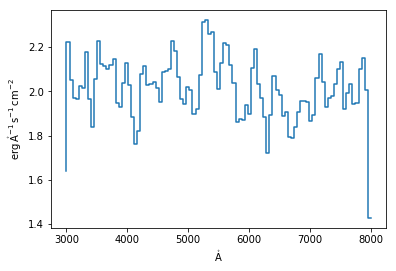

In [60]:
from specutils.manipulation import gaussian_smooth

smoothed_spec = gaussian_smooth(spec1d, 0.75)  # 0.75 pixel gaussian kernel
plt.step(smoothed_spec.wavelength, smoothed_spec.flux)

### Exercise

Try smoothing your spectrum loaded in the above example (or the SDSS spectrum).  Compare all available kernel types and decide which seems most appropriate for your spectrum.

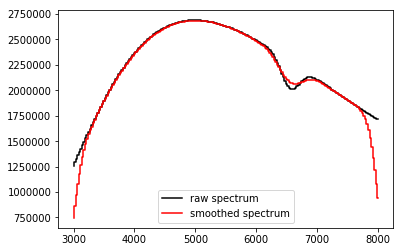

In [63]:
smoothed_BB_spec = gaussian_smooth(final_spec, 5)  # 5 pixel gaussian kernel

plt.errorbar(final_spec.wavelength.value, 
             final_spec.flux.value,
             fmt='-',
             drawstyle='steps-mid',
             color='k', label='raw spectrum')

plt.errorbar(smoothed_BB_spec.wavelength.value, 
             smoothed_BB_spec.flux.value,
             fmt='-',
             drawstyle='steps-mid',
             color='r', label='smoothed spectrum')
plt.legend()

# (Additional/optional) Exercise

This exercise moves somewhat beyond the scope of this overview, but may be useful for some use cases.  Try installing the specviz visualization tool:

https://specviz.readthedocs.io/en/stable/

Once this tool is installed, try loading your example spectrum.  While there may not be a loader already available for your spectrum, because `specviz` is based on `specutils`, your loader code developed above can be used to load your spectrum into specviz. Try this now and experiment with the quick-look GUI functionality available in specviz.

# Next Steps

While the above focuses on loading and viewing spectra, the next notebook is aimed at quantitative scientific analysis of these spectra. Go to the [Specutils analysis notebook](Specutils_analysis.ipynb) for more on this.